## Feature Selection |Correlation-based feature removal | Random Forest Feature Importance | Mutual Information | 

In [7]:
import pandas as pd

# Load the data
df = pd.read_csv('../Data/FE_reviews.csv')

# Check data
print(df.shape)
df.head()

(19328, 35)


,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,review_length,division_name_General Petite,division_name_Initmates,...,class_name_Lounge,class_name_Outerwear,class_name_Pants,class_name_Shorts,class_name_Skirts,class_name_Sleep,class_name_Sweaters,class_name_Swim,class_name_Trend,sentiment_score
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,98,0,0,...,0,0,0,0,0,0,0,0,0,0.9427
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,22,1,0,...,0,0,1,0,0,0,0,0,0,0.5727
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,36,0,0,...,0,0,0,0,0,0,0,0,0,0.9291
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,98,0,0,...,0,0,0,0,0,0,0,0,0,0.9419
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,101,1,0,...,0,0,0,0,0,0,0,0,0,0.8004


In [11]:
import pandas as pd
import numpy as np

# Example: load from CSV
X_structured = pd.read_csv('../Data/Womens Clothing E-Commerce Reviews.csv')

In [12]:
# check data type sand see
print(X_structured.dtypes)

non_numeric_cols = X_structured.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Index                       int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object
Non-numeric columns: ['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']


In [13]:
y = df['recommended_ind']
X_structured = df.drop(columns=['review_text', 'recommended_ind'], errors='ignore')

# drop the non-numeric 'title' column if present
X_structured = X_structured.drop(columns=['title'], errors='ignore')

# convert boolean columns to integers (true/false - 1/0)
for col in X_structured.columns:
    if X_structured[col].dtype == 'bool':
        X_structured[col] = X_structured[col].astype(int)
        

# scale structured data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)

# prepare TF-IdF matrix, (textual data)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df['review_text'].fillna(''))  # Handle missing text with fillna

# combine structured and Text features
from scipy.sparse import hstack

import numpy as np
X_combined = hstack([X_structured_scaled, X_tfidf])
print(f"Shape of structured data: {X_structured_scaled.shape}")
print(f"Shape of TF-IDF data: {X_tfidf.shape}")
print(f"Shape of combined data: {X_combined.shape}")

Shape of structured data: (19328, 32)
Shape of TF-IDF data: (19328, 1000)
Shape of combined data: (19328, 1032)


In [14]:
X_structured_df = pd.DataFrame(X_structured_scaled, columns=X_structured.columns)

# correlation matrix
corr_matrix = X_structured_df.corr().abs()  # absolute correlation

# upper tria. no duplicate pairs
import numpy as np

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation more than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Highly correlated features to drop: {to_drop}")

# drop these features
X_structured_df_selected = X_structured_df.drop(columns=to_drop)

# recombine with TF-IdF
from scipy.sparse import hstack

X_combined_selected = hstack([X_structured_df_selected.values, X_tfidf])

print(f"New shape of structured data after feature selection: {X_structured_df_selected.shape}")
print(f"New shape of combined data after feature selection: {X_combined_selected.shape}")

Highly correlated features to drop: ['department_name_Intimate', 'class_name_Dresses', 'class_name_Jackets', 'class_name_Trend']
New shape of structured data after feature selection: (19328, 28)
New shape of combined data after feature selection: (19328, 1028)


In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# fit Random forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_combined_selected, y)

# get feature importances
importances = rf_selector.feature_importances_

# take top 300 featueres
N = 300
indices = np.argsort(importances)[-N:]

# take those features
from scipy.sparse import csr_matrix

X_rf_selected = csr_matrix(X_combined_selected)[:, indices]

print(f"Shape after Random Forest feature selection: {X_rf_selected.shape}")

Shape after Random Forest feature selection: (19328, 300)


Used Random forest to select the top 300 most important features based on feature importance scores.

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Mutual information feature selection
k = 300  # take top 300 features
mi_selector = SelectKBest(mutual_info_classif, k=k)
X_mi_selected = mi_selector.fit_transform(X_combined_selected, y)

print(f"Shape after Mutual Information feature selection: {X_mi_selected.shape}")

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values b

Shape after Mutual Information feature selection: (19328, 300)


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values b

Applied mutual information to select features that have the strongest dependency with the target variable.

## Model Building/Training

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train/test split
X_train_rf, X_test_rf, y_train, y_test = train_test_split(X_rf_selected, y, test_size=0.2, random_state=42, stratify=y)

# Random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

# predictions
y_pred_rf = rf_model.predict(X_test_rf)
y_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]

# evaluation
print("Random Forest Feature Selection Results:")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}')

Random Forest Feature Selection Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88       680
           1       0.99      0.96      0.97      3186

    accuracy                           0.95      3866
   macro avg       0.91      0.95      0.93      3866
weighted avg       0.96      0.95      0.96      3866

ROC AUC Score: 0.9901


In [18]:
# Train/test split
X_train_mi, X_test_mi, _, _ = train_test_split(X_mi_selected, y, test_size=0.2, random_state=42, stratify=y)

# Random forest model
rf_model_mi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_mi.fit(X_train_mi, y_train)

# predictions
y_pred_mi = rf_model_mi.predict(X_test_mi)
y_proba_mi = rf_model_mi.predict_proba(X_test_mi)[:, 1]

# evaluation
print("mutual info feat selection output:")
print("classification Report:\n", classification_report(y_test, y_pred_mi))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_mi):.4f}')

mutual info feat selection output:
classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       680
           1       0.98      0.96      0.97      3186

    accuracy                           0.95      3866
   macro avg       0.91      0.94      0.92      3866
weighted avg       0.96      0.95      0.95      3866

ROC AUC Score: 0.9904


Plotingg roc curves to visually compare the classification performance of both models based on different feature selection techniques. and extract,save the feature importance scores from the random forest model to identify which features contributed most to the predictions.

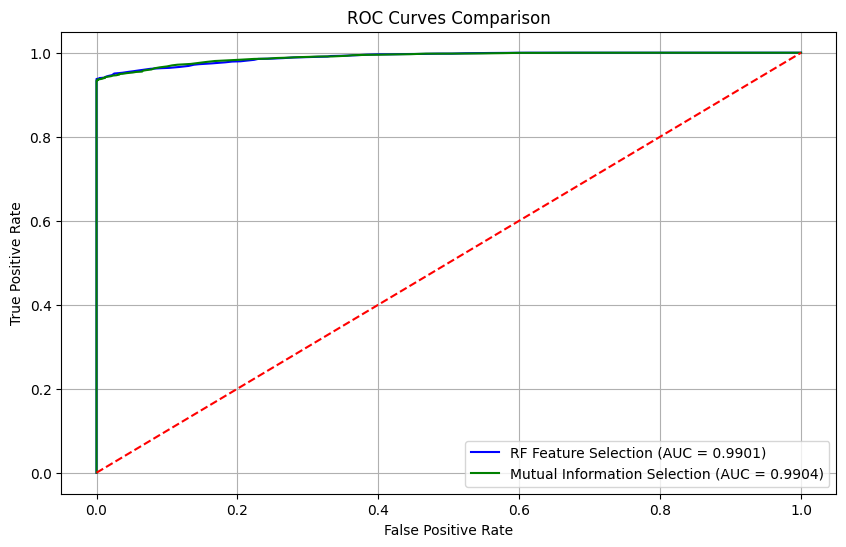

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# roc curve for Random forest (feature importancee)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC curve for random forest (mutual information)
fpr_mi, tpr_mi, _ = roc_curve(y_test, y_proba_mi)
roc_auc_mi = auc(fpr_mi, tpr_mi)

# plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Feature Selection (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Information Selection (AUC = {roc_auc_mi:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [20]:
# export feature importances
feature_importances = rf_model.feature_importances_

import pandas as pd
feature_importances_df = pd.DataFrame({
    'Feature Index': indices,
    'Importance': feature_importances
})

# sorting by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# save 
print(feature_importances_df.head(10))
feature_importances_df.to_csv('feature_importances_rf.csv', index=False)

     Feature Index  Importance
299              2    0.456788
298             27    0.062731
297            263    0.013318
291            961    0.011308
292              4    0.009250
293            175    0.008500
285              0    0.008311
296            510    0.008290
286              1    0.008276
290            428    0.008232


In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# for RF model (feature importance)
y_pred_mi = rf_model_mi.predict(X_test_mi)

accuracy_mi = accuracy_score(y_test, y_pred_mi)
f1_mi = f1_score(y_test, y_pred_mi)

print(f"Accuracy (Mutual Information Feature Selection): {accuracy_mi:.4f}")
print(f"F1 Score (Mutual Information Feature Selection): {f1_mi:.4f}")
print("\nClassification Report (Mutual Information Feature Selection):")
print(classification_report(y_test, y_pred_mi))

Accuracy (Mutual Information Feature Selection): 0.9534
F1 Score (Mutual Information Feature Selection): 0.9714

Classification Report (Mutual Information Feature Selection):
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       680
           1       0.98      0.96      0.97      3186

    accuracy                           0.95      3866
   macro avg       0.91      0.94      0.92      3866
weighted avg       0.96      0.95      0.95      3866

